In [1]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import typing as t
import scipy.stats as stats

# Common function definitions

In [2]:
def bootstrap(data: np.ndarray, n: int, func: t.Callable[[np.ndarray], float]) -> np.ndarray:
    """Bootstrap the data."""
    # Data should be a 1D array
    assert data.ndim == 1

    aggregated_data = np.apply_along_axis(
        func, 
        axis=1, 
        arr=np.random.choice(data, size=(n, data.shape[0]), replace=True)
    )

    # Return the mean of the aggregated data
    return aggregated_data

def bootstrap_reduce(data: np.ndarray, n: int, func: t.Callable[[np.ndarray], float]) -> np.ndarray:
    """Bootstrap the data."""
    return bootstrap(data, n, func).mean(axis=0)

# Load the data and check summary statistics

This data is available at: https://www.kode24.no/artikkel/utvikleres-lonn-2023-over-200000-skiller-vinner-fra-taper/79011963

In [3]:
df_raw = pd.read_csv(Path('data/kode24_lønn_2023_vår.csv'), sep=',')

# Remove rows where the column "Lønn" is NaN
df_base = df_raw[df_raw['lønn'].notna()]

In [4]:
df_base.head()

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
0,21-25,2.0,5.0,"in-house, privat sektor",Oslo,sikkerhet,100 - 500,350000.0,Ja,Ja
1,26-30,0.0,1.0,"in-house, privat sektor",Innlandet,fullstack,100 - 500,350000.0,Nei,Nei
2,31-35,3.0,14.0,"in-house, privat sektor",Viken,ingen av disse,100 - 500,350000.0,Nei,Nei
3,26-30,NaN,3.0,frilans / selvstendig næringsdrivende,Oslo,frontend,under 10,350000.0,Ja,Nei
4,31-35,4.0,0.0,"in-house, privat sektor",Viken,fullstack,under 10,350000.0,Nei,Nei


In [5]:
df_base.describe()

,utdanning,erfaring,lønn
count,2234.000000,2303.000000,2.306000e+03
mean,3.529543,8.832827,8.435237e+05
std,1.738960,7.833926,2.919897e+05
min,0.000000,0.000000,3.500000e+05
25%,3.000000,3.000000,6.500000e+05
50%,3.000000,6.000000,7.900000e+05
75%,5.000000,13.000000,9.600000e+05
max,10.000000,45.000000,3.500000e+06


In [6]:
# Count the number of rows with nans for each column
df_base.isna().sum()

alder         0
utdanning    72
erfaring      3
jobb          0
sted          0
fag           0
kolleger      0
lønn          0
bonus         0
fornøyd       0
dtype: int64

# Plot salary data

In this section, we plot the salary data to get an overview of the situation.

25th percentile: 650000.0
Median: 790000.0
75th percentile: 960000.0


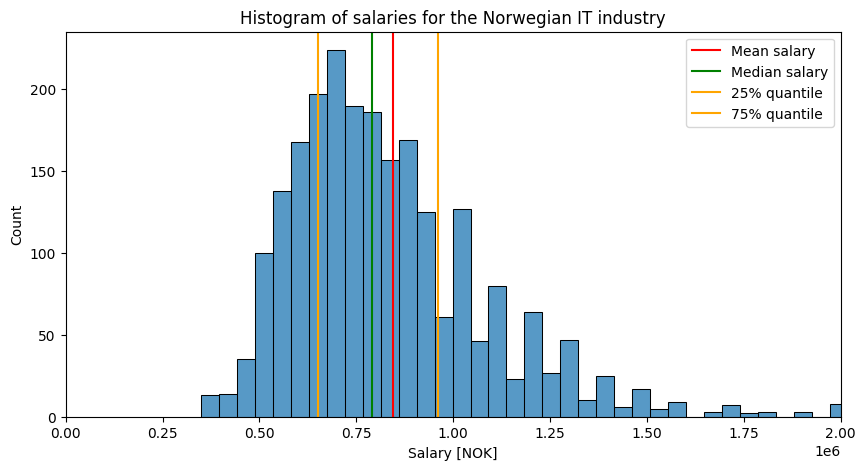

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

df = df_base.copy()

# Draw a histogram of the column "lønn"
sns.histplot(df['lønn'], ax=ax)

# Draw vertical lines at points of interest.
ax.axvline(df['lønn'].mean(), color='red', label='Mean salary')
ax.axvline(df['lønn'].median(), color='green', label='Median salary')
ax.axvline(df['lønn'].quantile(0.25), color='orange', label='25% quantile')
ax.axvline(df['lønn'].quantile(0.75), color='orange', label='75% quantile')

ax.set(title='Histogram of salaries for the Norwegian IT industry', xlabel='Salary [NOK]', ylabel='Count')
ax.set_xlim(0, 2e6)
ax.legend()

print(f"25th percentile: {df['lønn'].quantile(0.25)}")
print(f"Median: {df['lønn'].median()}")
print(f"75th percentile: {df['lønn'].quantile(0.75)}")

# Analyzing the effect of experience on salary

First off, we need to analyze what kind of model we should use. To figure this out, let's see if the data is linear using a QQ-plot.

Our conclusion is that the data is not linear, so we need to use a non-linear model or transform the data.

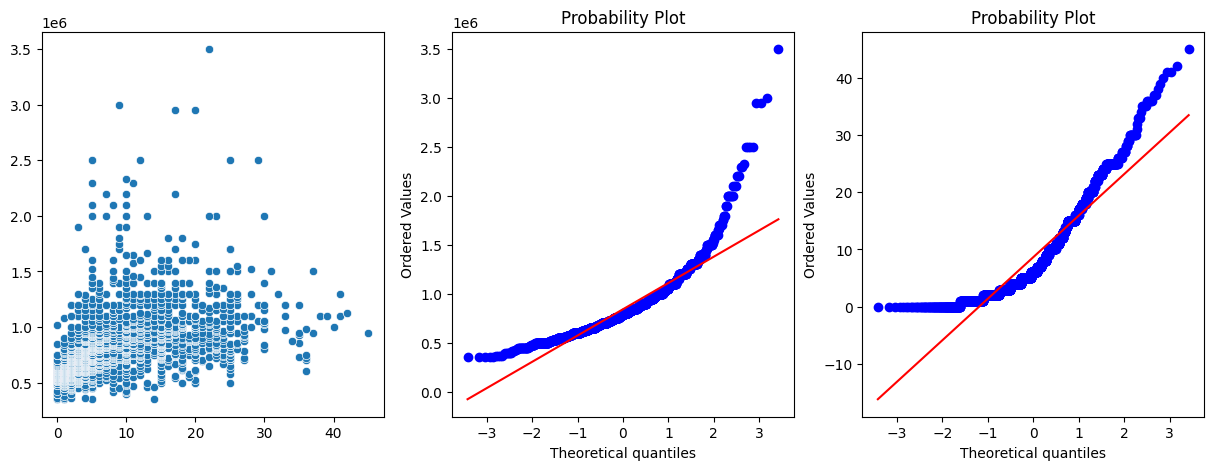

In [8]:
df = df_base.copy().dropna()
df = df[['lønn', 'erfaring']]
X = df[['erfaring']].to_numpy()
y = df['lønn'].to_numpy()

# Draw a scatter plot.
fig, (ax_scatter, ax_qq1, ax_qq2) = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(x=X[:, 0], y=y, ax=ax_scatter)

# Draw a qq plot.
stats.probplot(y, plot=ax_qq1)
stats.probplot(X.reshape(-1), plot=ax_qq2);


Our first approach at analyzing the data will be to bootstrap the means of the salary data for every year of experience.

In [9]:
df = df_base.copy()
df = df[['lønn', 'erfaring']]
df = df.dropna()

df = df[df['lønn'] < 2_000_000]
df = df[df['erfaring'] < 25]

X = df[['erfaring']].to_numpy()
y = df['lønn'].to_numpy()

def apply_percentile(data: np.ndarray, percentile: float=50) -> float:
    """Apply a percentile to the data."""
    try:
        return np.percentile(data, percentile)
    except Exception:
        return np.nan

def apply_mean(data: np.ndarray) -> float:
    """Apply a percentile to the data."""
    try:
        return data.mean()
    except Exception:
        return np.nan

# For every year of experience, calculate the mean salary
df_bootstrapped = pd.DataFrame({'erfaring': range(int(df['erfaring'].min()), int(df['erfaring'].max()))})
df_bootstrapped['lønn_mean'] = df_bootstrapped['erfaring'].apply(lambda x: bootstrap_reduce(df[df['erfaring'] == x]['lønn'].to_numpy(), 1000, apply_mean))

We will now attempt to reason about the relationship between experience and salary.

It seems that between 0-9 years of experience, there is a linear relationship between experience and salary. After that, the relationship is not linear anymore. This might be because we have limited amounts of data.

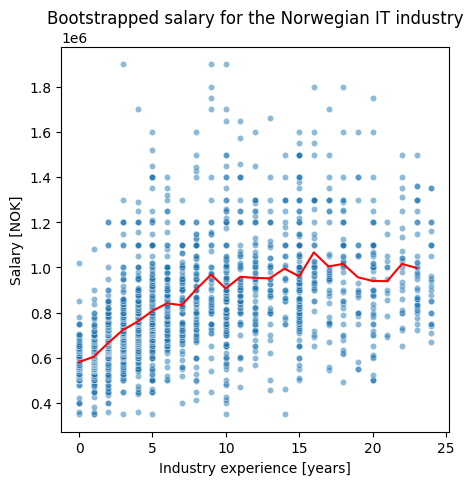

In [10]:
# # Plot the mean salary
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(x=X[:, 0], y=y, ax=ax, alpha=0.5, s=20)
sns.lineplot(x=df_bootstrapped['erfaring'], y=df_bootstrapped['lønn_mean'], ax=ax, color='red')

ax.set_title('Bootstrapped salary for the Norwegian IT industry')
ax.set_xlabel('Industry experience [years]')
ax.set_ylabel('Salary [NOK]');

In [11]:
df_10years = df_bootstrapped[df_bootstrapped['erfaring'] <= 9]

# Get the lønn_mean at 0 and 10 years.
lønn_mean_0years = df_10years[df_10years['erfaring'] == 0]['lønn_mean'].to_numpy()[0]
lønn_mean_9years = df_10years[df_10years['erfaring'] == 9]['lønn_mean'].to_numpy()[0]

# Calculate the slope between the two points.
slope = (lønn_mean_9years - lønn_mean_0years) / 9
print(f"The mean starting salary is somewhere around {lønn_mean_0years:.2f} NOK.")
print(f"Every year of experience is worth {slope:.2f} NOK.")

The mean starting salary is somewhere around 581546.76 NOK.
Every year of experience is worth 42989.68 NOK.
